In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [2]:
data = yf.download('AAPL', start='2016-01-01', end='2022-12-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.074739,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.471443,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.012114,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.040899,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.157440,283192000


In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-23,149.449997,151.830002,149.339996,151.070007,150.839706,58301400
2022-11-25,148.309998,148.880005,147.119995,148.110001,147.884201,35195900
2022-11-28,145.139999,146.639999,143.380005,144.220001,144.000137,69246000
2022-11-29,144.289993,144.809998,140.350006,141.169998,140.954788,83763800
2022-11-30,141.399994,148.720001,140.550003,148.029999,147.804321,111380900


Text(0, 0.5, 'Prices ($)')

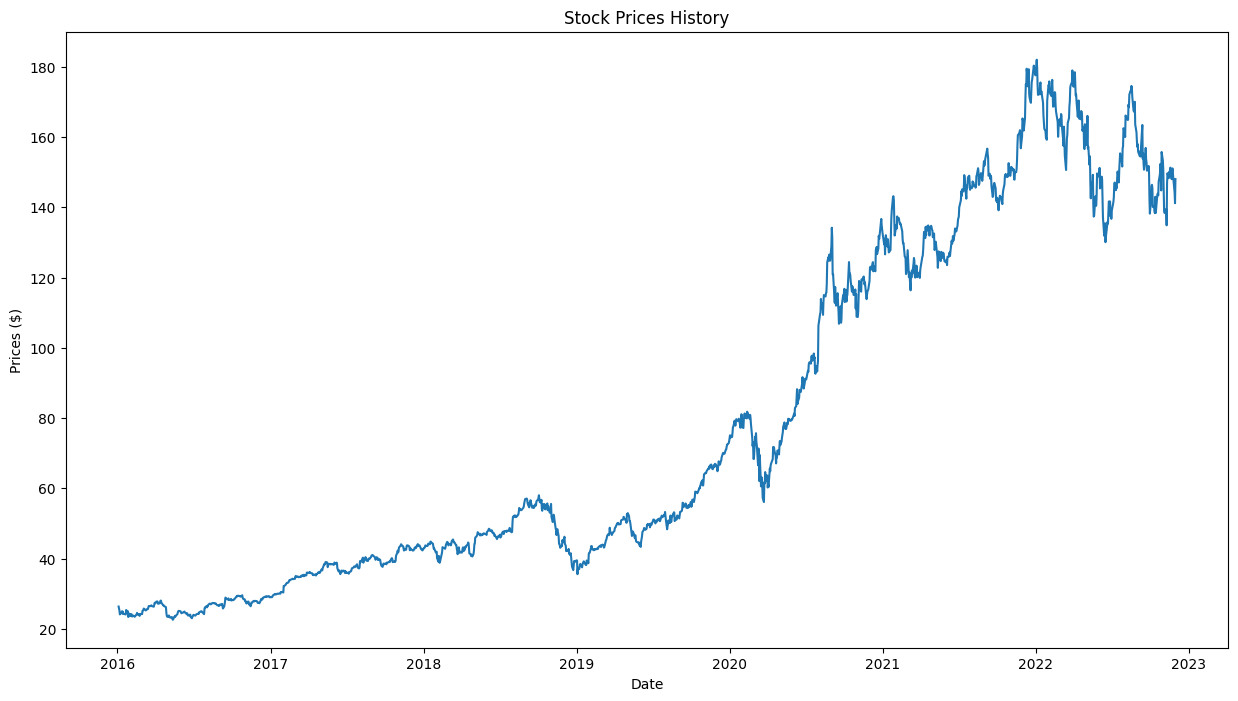

In [5]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**Preparation of training set**

Here we will only need the closing prices from our dataset to train our LSTM model. We are going to extract 80% of the closing prices from our acquired stock data as our training set.

Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer.

In [8]:
close_prices = data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)


Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array.

In [9]:

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

Set apart the first 80% of the stock data as the training set.

In [10]:
train_data = scaled_data[0: training_data_len, :]

In [11]:
train_data

array([[0.02353772],
       [0.01939784],
       [0.01624589],
       ...,
       [0.77186767],
       [0.79388426],
       [0.78968167]])

 Create an empty list for a sequence of feature data (x_train) and a sequence of label data (y_train).

In [12]:
x_train = []
y_train = []

Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label data (y_train).

In [13]:
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Preparation of test data**
Extract the closing prices from our normalized dataset (the last 20% of the dataset).

In [14]:
test_data = scaled_data[training_data_len-60: , : ]

create feature data (x_test) and label data (y_test)from our test set.

In [15]:
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

Convert the feature data (x_test) and label data (y_test) into Numpy array. Reshape again the x_test and y_test into a three-dimensional array

In [16]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

**LSTM**

In [17]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


**Training LSTM Model**

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [19]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 161ms/step - loss: 0.0123 - val_loss: 23999.0508
Epoch 2/100
21/21 [==============================] - 2s 119ms/step - loss: 6.9958e-04 - val_loss: 24030.6621
Epoch 3/100
21/21 [==============================] - 3s 124ms/step - loss: 3.9531e-04 - val_loss: 24017.6660
Epoch 4/100
21/21 [==============================] - 3s 131ms/step - loss: 3.4031e-04 - val_loss: 24024.0488
Epoch 5/100
21/21 [==============================] - 3s 125ms/step - loss: 3.4001e-04 - val_loss: 24020.3945
Epoch 6/100
21/21 [==============================] - 3s 134ms/step - loss: 3.2188e-04 - val_loss: 24020.2969
Epoch 7/100
21/21 [==============================] - 3s 135ms/step - loss: 3.1891e-04 - val_loss: 24015.5020
Epoch 8/100
21/21 [==============================] - 3s 139ms/step - loss: 3.2871e-04 - val_loss: 24016.0508
Epoch 9/100
21/21 [==============================] - 3s 138ms/step - loss: 3.0796e-04 - val_loss: 24019.2793
Epoch 10/100
21/21 [===

21/21 [==============================] - 7s 319ms/step - loss: 1.3970e-04 - val_loss: 24021.2246
Epoch 76/100
21/21 [==============================] - 7s 327ms/step - loss: 1.0993e-04 - val_loss: 24024.0137
Epoch 77/100
21/21 [==============================] - 6s 279ms/step - loss: 1.0584e-04 - val_loss: 24020.1348
Epoch 78/100
21/21 [==============================] - 7s 341ms/step - loss: 9.9250e-05 - val_loss: 24017.7168
Epoch 79/100
21/21 [==============================] - 9s 438ms/step - loss: 1.1258e-04 - val_loss: 24018.8457
Epoch 80/100
21/21 [==============================] - 7s 343ms/step - loss: 9.5034e-05 - val_loss: 24017.1816
Epoch 81/100
21/21 [==============================] - 6s 270ms/step - loss: 9.7337e-05 - val_loss: 24020.2949
Epoch 82/100
21/21 [==============================] - 7s 315ms/step - loss: 1.0276e-04 - val_loss: 24014.4219
Epoch 83/100
21/21 [==============================] - 5s 227ms/step - loss: 1.3437e-04 - val_loss: 24019.4609
Epoch 84/100
21/21 [===

**Model Evaluation**

In [20]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

11/11 [==============================] - 2s 21ms/step


0.4510633095927622

The result shows that the RMSE is only as low as about 0.45, The model is seemingly working well.

**Visualizing the Predicted Prices**

C:\Users\Punam\AppData\Local\Temp\ipykernel_11552\1411916989.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


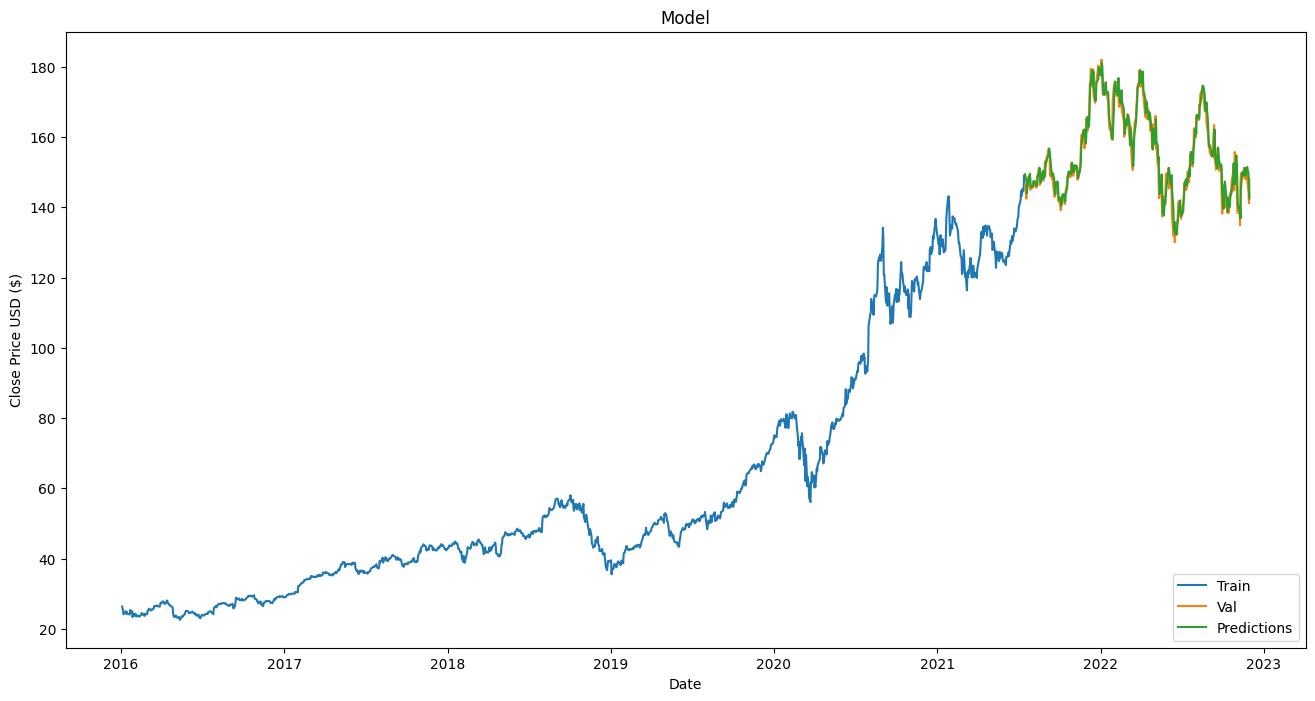

In [23]:
data = data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show() 